This notebook performs downstream Drug Response Prediction with the augmented cell line data and patient datasets. Uses a neural network to perform DRP. Augmented data is in the latent space of the patient VAE (used with DDPM)

Majority voting is used to get the pseudo labels.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [3]:
from scipy.stats import mode

In [4]:
import sys
sys.path.append("../src/tab_ddpm/")

In [5]:
sys.path.append("../src/")
from vae_model import vae

In [6]:
device = torch.device("cuda:0")

In [7]:
torch.manual_seed(0)

In [8]:
sample_id = 1

#### Load Datasets

In [9]:
tcga_train_df = pd.read_csv(f"../data/diffusion_pretraining/tcga_diffusion_train_sample{sample_id}.csv", index_col=0)
tcga_train_df.shape

(476, 7776)

In [10]:
tcga_test_df = pd.read_csv(f"../data/diffusion_pretraining/tcga_diffusion_test_sample{sample_id}.csv", index_col=0)
tcga_test_df.shape

(120, 7776)

In [11]:
# pass data points through patient DDPM and get the input to VAE decoder for DRP
from gaussian_multinomial_diffusion import GaussianMultinomialDiffusion
from modules import MLPDiffusion

tcga_mlp_diffusion_model = MLPDiffusion(d_in=64, num_classes=0, is_y_cond=False, rtdl_params={"d_layers": [32], "dropout": 0.1}).to(device)
tcga_diff_model = GaussianMultinomialDiffusion(num_classes=np.array([0]), num_numerical_features=64, denoise_fn=tcga_mlp_diffusion_model, device=device)
tcga_diff_model.load_state_dict(torch.load(f"/data/ajayago/druid/intermediate/cs6220/sample{sample_id}/tcga_diff_model_clconditioned_uda_v2.pth"))

<All keys matched successfully>

In [12]:
tcga_vae = vae(input_dim=7776, k_list=[512, 128], actf_list=["tanh", "tanh"], is_real=True)
tcga_vae.load_state_dict(torch.load(f"/data/ajayago/druid/intermediate/cs6220/sample{sample_id}/vae_patient_clconditioned_uda_v2.pth"))
tcga_vae.to(device)

U: encoder 
Sequential(
  (enc-0): Linear(in_features=7776, out_features=512, bias=True)
  (act-0): Tanh()
  (enc-1): Linear(in_features=512, out_features=128, bias=True)
  (act-1): Tanh()
)
#
mu_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
sigma_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
U: decoder 
Sequential(
  (-dec-0): Linear(in_features=64, out_features=128, bias=True)
  (-act-0): Tanh()
  (dec-0): Linear(in_features=128, out_features=512, bias=True)
  (act-0): Tanh()
  (dec-1): Linear(in_features=512, out_features=7776, bias=True)
  (act-1): Tanh()
)


vae(
  (mu_layer): Linear(in_features=128, out_features=64, bias=True)
  (sigma_layer): Linear(in_features=128, out_features=64, bias=True)
  (encoder): Sequential(
    (enc-0): Linear(in_features=7776, out_features=512, bias=True)
    (act-0): Tanh()
    (enc-1): Linear(in_features=512, out_features=128, bias=True)
    (act-1): Tanh()
  )
  (decoder): Sequential(
    (-dec-0): Linear(in_features=64, out_features=128, bias=True)
    (-act-0): Tanh()
    (dec-0): Linear(in_features=128, out_features=512, bias=True)
    (act-0): Tanh()
    (dec-1): Linear(in_features=512, out_features=7776, bias=True)
    (act-1): Tanh()
  )
)

In [13]:
def tcga_vae_decoder_input(df):
    with torch.no_grad():
        batch = torch.tensor(df.values)
        inp_vae = batch.to(device, dtype=torch.float32)
        inp, mu, logvar, _ = tcga_vae(inp_vae) # From VAE encoder + reparameterization
        
        noise = torch.randn_like(inp) # this is the label we use   
        b = inp.shape[0]
        t = (torch.ones((b,)) * 700).long().to(device) # fixing time steps to 700
        pt = torch.ones_like(t).float() / tcga_diff_model.num_timesteps
        inp_t = tcga_diff_model.gaussian_q_sample(inp, t, noise) # forward process with cell line model encoder
        
        model_out = tcga_diff_model._denoise_fn(inp_t, t) # predicted epsilon from patient decoder
    
        # predict inp from noise using patient model
        inp_pred = tcga_diff_model._predict_xstart_from_eps(inp_t, t, model_out)

    return inp_pred

In [14]:
# TCGA train data
tcga_train_vae = tcga_vae_decoder_input(tcga_train_df)
tcga_train_vae.shape

torch.Size([476, 64])

In [15]:
# TCGA test data
tcga_test_vae = tcga_vae_decoder_input(tcga_test_df)
tcga_test_vae.shape

torch.Size([120, 64])

In [16]:
tcga_train_df_vae = pd.DataFrame(tcga_train_vae.detach().cpu().numpy(), columns = [f"vae_feat{i}" for i in range(0, tcga_train_vae.shape[1])], index = tcga_train_df.index)
tcga_test_df_vae = pd.DataFrame(tcga_test_vae.detach().cpu().numpy(), columns = [f"vae_feat{i}" for i in range(0, tcga_test_vae.shape[1])], index = tcga_test_df.index)

In [17]:
# augmented_cl_df = pd.read_csv(f"/data/ajayago/druid/intermediate/cs6220/sample{sample_id}/augmented_cl_joint_UDA.csv", index_col=0) # only UDA + LDM
# augmented_cl_df = pd.read_csv(f"/data/ajayago/druid/intermediate/cs6220/sample{sample_id}/augmented_cl_clconditioned.csv", index_col=0) # no UDA, only conditioning
# augmented_cl_df = pd.read_csv(f"/data/ajayago/druid/intermediate/cs6220/sample{sample_id}/augmented_cl_clconditioned_uda.csv", index_col=0) # all possible losses
augmented_cl_df = pd.read_csv(f"/data/ajayago/druid/intermediate/cs6220/sample{sample_id}/augmented_cl_clconditioned_uda_v2_vaeinput_64dim.csv", index_col=0) # without KLD, MSE mean in training. Only uses Gaussian loss from TDDPM and coral loss
print(augmented_cl_df.shape)
augmented_cl_df

(1744, 64)


,vae_feat0,vae_feat1,vae_feat2,vae_feat3,vae_feat4,vae_feat5,vae_feat6,vae_feat7,vae_feat8,vae_feat9,...,vae_feat54,vae_feat55,vae_feat56,vae_feat57,vae_feat58,vae_feat59,vae_feat60,vae_feat61,vae_feat62,vae_feat63
ACH-000816,-0.486760,0.619201,0.767806,1.799033,-1.623706,0.947527,-1.716471,-2.628437,-3.432042,1.136709,...,-1.541179,0.203393,3.025950,1.355511,-0.964442,1.795823,0.223080,0.487219,4.425227,-2.856314
ACH-002338,0.248799,-0.402038,1.520589,3.537819,2.979399,-0.993929,-0.641541,-2.335733,2.058732,-0.127629,...,1.290275,0.301937,-0.002051,2.992442,-0.337362,-1.331393,-1.787926,-0.015908,-3.342188,0.489116
ACH-000915,-1.422066,-0.601764,-0.108578,-5.343997,-0.067796,1.446081,-1.685952,-0.420934,2.649791,0.709253,...,2.361031,1.398032,-1.218997,0.829817,-0.974172,-3.099377,-0.038206,1.255138,0.004945,-2.218665
ACH-000134,-0.530464,-0.297018,-2.641105,-0.089057,-0.689541,-0.717783,-0.757098,2.320428,-1.933385,1.392428,...,-0.504080,-0.815348,1.239754,2.336094,1.648087,0.175907,-1.051083,1.217736,0.636256,1.146197
ACH-000453,0.376342,0.209323,2.025030,-0.279278,-2.287806,-1.743337,2.139492,1.923822,-1.094573,0.377853,...,-2.421293,-1.637690,1.279590,-2.699091,-2.777397,1.341821,0.326492,-1.717786,0.202250,-2.233815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002094,-1.916418,2.082823,-0.138187,-0.274417,1.665307,-0.190609,-1.516747,-0.461327,1.719864,0.027714,...,-1.770138,-0.018593,-2.387622,-0.661610,-2.565128,2.913600,-2.089172,-0.564254,2.840710,0.546586
ACH-000495,-1.675604,-0.301439,-1.270202,1.468626,0.057898,1.485031,-1.099440,0.322815,0.267987,-0.108868,...,-1.426252,1.601271,0.799412,-0.974761,-2.067341,2.957002,0.599696,-2.939243,-0.263825,2.660889
ACH-001346,-1.090935,1.453332,-1.927124,-0.458730,0.640607,2.159293,0.031491,1.347735,1.503320,-1.641855,...,0.859159,3.081894,0.480204,-0.771371,0.716897,-1.022769,-3.702365,0.464099,-0.465824,-0.333126
ACH-001151,-1.845456,-0.317731,1.912693,1.858728,1.722436,-3.255141,3.084964,-1.997395,2.038843,2.677902,...,-1.236551,-0.941287,0.770682,1.213760,3.523725,-2.209888,-1.258581,1.004687,-2.171236,-1.677340


#### Load response files

In [18]:
cl_responses_df = pd.read_csv("/data/ajayago/copied_from_cdal1/yiming_data_folder/dataset/CellLine/patient_auc.csv")
cl_responses_df

,depmap_id,drug_name,auc
0,ACH-000001,JW-7-24-1,0.778432
1,ACH-000002,JW-7-24-1,0.788327
2,ACH-000004,JW-7-24-1,0.737630
3,ACH-000006,JW-7-24-1,0.176396
4,ACH-000007,JW-7-24-1,0.569751
...,...,...,...
226791,ACH-001702,SL 0101-1,0.958591
226792,ACH-001703,SL 0101-1,0.497201
226793,ACH-001711,SL 0101-1,0.815928
226794,ACH-001715,SL 0101-1,0.981441


In [19]:
patient_responses_df = pd.read_csv("/data/ajayago/copied_from_cdal1/ajayago_home_folder/processed/TCGA_drug_response_010222.csv")
patient_responses_df

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EC,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EC,Doxorubicin,Partial Response,1,DOXORUBICIN
2,TCGA-G2-A2EC,Vinblastine,Partial Response,1,VINBLASTINE
3,TCGA-G2-A2EC,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-G2-A2EJ,Paclitaxel,Stable Disease,0,PACLITAXEL
...,...,...,...,...,...
1244,TCGA-BG-A0VZ,Cisplatin,Complete Response,1,CISPLATIN
1245,TCGA-BG-A0VZ,Paclitaxel,Complete Response,1,PACLITAXEL
1246,TCGA-BG-A0VZ,Doxorubicin,Complete Response,1,DOXORUBICIN
1247,TCGA-BG-A0VT,Carboplatin,Complete Response,1,CARBOPLATIN


In [20]:
patient_responses_df["drug"].value_counts()

drug
CISPLATIN             206
5-FLUOROURACIL        125
CARBOPLATIN           117
PACLITAXEL            113
CYCLOPHOSPHAMIDE       69
                     ... 
E7389                   1
CARMUSTINE              1
TEMOZOLOMIDE            1
ERIBULIN                1
METHYLPREDNISOLONE      1
Name: count, Length: 69, dtype: int64

In [21]:
patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_test_df.index)].drug.value_counts()

drug
CISPLATIN           47
PACLITAXEL          26
CARBOPLATIN         20
5-FLUOROURACIL      18
GEMCITABINE         17
CYCLOPHOSPHAMIDE    14
DOXORUBICIN         13
DOCETAXEL           12
LEUCOVORIN           6
CETUXIMAB            6
DACARBAZINE          6
VINORELBINE          6
ETOPOSIDE            5
TAMOXIFEN            4
VINBLASTINE          4
CAPECITABINE         4
IFOSFAMIDE           3
METHOTREXATE         3
PEMETREXED           3
OXALIPLATIN          3
TRASTUZUMAB          2
EPIRUBICIN           2
ANASTROZOLE          2
TOPOTECAN            2
IRINOTECAN           2
ERLOTINIB            2
ALDESLEUKIN          2
PEGFILGRASTIM        1
LEUPROLIDE           1
PAMIDRONATE          1
GOSERELIN            1
LAPATINIB            1
GEFITINIB            1
DABRAFENIB           1
VEMURAFENIB          1
FOTEMUSTINE          1
DACTINOMYCIN         1
MELPHALAN            1
VINCRISTINE          1
AXITINIB             1
Name: count, dtype: int64

In [22]:
patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_train_df.index)].drug.value_counts()

drug
CISPLATIN             159
5-FLUOROURACIL        107
CARBOPLATIN            97
PACLITAXEL             87
CYCLOPHOSPHAMIDE       55
                     ... 
PNU-159548              1
RESIQUIMOD              1
TOREMIFENE              1
ERIBULIN                1
METHYLPREDNISOLONE      1
Name: count, Length: 67, dtype: int64

In [23]:
train_tcga_with_response = patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_train_df.index)].reset_index(drop=True)
train_tcga_with_response

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EC,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EC,Doxorubicin,Partial Response,1,DOXORUBICIN
2,TCGA-G2-A2EC,Vinblastine,Partial Response,1,VINBLASTINE
3,TCGA-G2-A2EC,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-G2-A2EJ,Paclitaxel,Stable Disease,0,PACLITAXEL
...,...,...,...,...,...
997,TCGA-QS-A8F1,Paclitaxel,Clinical Progressive Disease,0,PACLITAXEL
998,TCGA-2E-A9G8,Paclitaxel,Complete Response,1,PACLITAXEL
999,TCGA-2E-A9G8,Carboplatin,Complete Response,1,CARBOPLATIN
1000,TCGA-BG-A0VT,Carboplatin,Complete Response,1,CARBOPLATIN


In [24]:
test_tcga_with_response = patient_responses_df[patient_responses_df["patient.arr"].isin(tcga_test_df.index)].reset_index(drop=True)
test_tcga_with_response

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EK,Methotrexate,Stable Disease,0,METHOTREXATE
1,TCGA-G2-A2EK,Doxorubicin,Stable Disease,0,DOXORUBICIN
2,TCGA-G2-A2EK,Vinblastine,Stable Disease,0,VINBLASTINE
3,TCGA-G2-A2EK,Cisplatin,Stable Disease,0,CISPLATIN
4,TCGA-DK-A3IQ,Gemcitabine,Stable Disease,0,GEMCITABINE
...,...,...,...,...,...
242,TCGA-QS-A5YQ,Carboplatin,Complete Response,1,CARBOPLATIN
243,TCGA-QS-A5YQ,Paclitaxel,Complete Response,1,PACLITAXEL
244,TCGA-BG-A0VZ,Cisplatin,Complete Response,1,CISPLATIN
245,TCGA-BG-A0VZ,Paclitaxel,Complete Response,1,PACLITAXEL


In [25]:
drug_fp = pd.read_csv("/data/ajayago/copied_from_cdal1/ajayago_home_folder/processed/drug_morgan_fingerprints.csv", index_col = 0)
drug_fp

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
drug_name,,,,,,,,,,,,,,,,,,,,,
JW-7-24-1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KIN001-260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NSC-87877,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
GNE-317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NAVITOCLAX,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LGH447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRASTUZUMAB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WNT974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
set(train_tcga_with_response["drug"]) - set(drug_fp.index)

{'ALDESLEUKIN',
 'ANASTROZOLE',
 'BCG',
 'CAPECITABINE',
 'CARBOPLATIN',
 'CYCLOSPORINE',
 'DEXAMETHASONE',
 'DIDOX',
 'E7389',
 'ERIBULIN',
 'EXEMESTANE',
 'FOLFIRI',
 'FOLFOX',
 'FOTEMUSTINE',
 'GOSERELIN',
 'GP100',
 'HYDROCORTISONE',
 'IFOSFAMIDE',
 'LETROZOLE',
 'LEUCOVORIN',
 'LEUPROLIDE',
 'LOMUSTINE',
 'MELPHALAN',
 'METHYLPREDNISOLONE',
 'MYCOPHENOLIC ACID',
 'ONDANSETRON',
 'PAMIDRONATE',
 'PEGFILGRASTIM',
 'PNU-159548',
 'PX-866',
 'REGORAFENIB',
 'RESIQUIMOD',
 'TOREMIFENE',
 'VEMURAFENIB'}

In [27]:
set(test_tcga_with_response["drug"]) - set(drug_fp.index)

{'ALDESLEUKIN',
 'ANASTROZOLE',
 'CAPECITABINE',
 'CARBOPLATIN',
 'FOTEMUSTINE',
 'GOSERELIN',
 'IFOSFAMIDE',
 'LEUCOVORIN',
 'LEUPROLIDE',
 'MELPHALAN',
 'PAMIDRONATE',
 'PEGFILGRASTIM',
 'VEMURAFENIB'}

Plan:

* Baseline: Train a model on train patient data + drug fingerprints and predict the response for the (patient, drug) pair.
* Add all cell lines and assign pseudo labels using the patient model from baseline - concat both datasets and train another model.
* Weak supervision + subset selection on cell lines - use this with patient data to train another model

Evaluation: Classification metrics on the patient test dataset.

In [28]:
# using data loaders to prevent execessive memory usage
class CustomTcgaDataSet(TensorDataset):
    def __init__(self, sample_df): # sample_df must only consist of samples with drug name with a fingerprint
        self.sample_df = sample_df.reset_index(drop=True) # ensure idx refers to a continuous set of values

    def __getitem__(self, idx):
        row = self.sample_df.iloc[idx]
        sample_name = row["patient.arr"]
        drug_name = row["drug"]
        if sample_name in tcga_train_df_vae.index: # using VAE version instead of mutation profiles
            mut_profile = tcga_train_df_vae.loc[sample_name].values
        if sample_name in tcga_test_df_vae.index:
            mut_profile = tcga_test_df_vae.loc[sample_name].values
        drug_inp = drug_fp.loc[drug_name].values
        inp = []
        inp.extend(mut_profile)
        inp.extend(drug_inp)
        response = row["response_cat"]
        return torch.tensor(inp), response

    def __len__(self):
        return len(self.sample_df)
        

In [29]:
# using data loaders to prevent execessive memory usage
class CustomCellLineDataSet(TensorDataset):
    def __init__(self, sample_df): # sample_df must only consist of samples with drug name with a fingerprint
        self.sample_df = sample_df.reset_index(drop=True) # ensure idx refers to a continuous set of values

    def __getitem__(self, idx):
        row = self.sample_df.iloc[idx]
        sample_name = row["depmap_id"]
        drug_name = row["drug_name"]
        mut_profile = augmented_cl_df.loc[sample_name].values
        drug_inp = drug_fp.loc[drug_name].values
        inp = []
        inp.extend(mut_profile)
        inp.extend(drug_inp)
        response = row["auc"]
        return torch.tensor(inp), response

    def __len__(self):
        return len(self.sample_df)
        

In [30]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

In [31]:
test_tcga_with_response = test_tcga_with_response[test_tcga_with_response.drug.isin(drug_fp.index)].reset_index(drop=True)
test_tcga_with_response.shape

(203, 5)

In [32]:
test_dataset = CustomTcgaDataSet(sample_df = test_tcga_with_response)
len(test_dataset)

203

In [33]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Baseline Model

In [34]:
train_tcga_with_response = train_tcga_with_response[train_tcga_with_response.drug.isin(drug_fp.index)].reset_index(drop=True)
train_tcga_with_response

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EC,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EC,Doxorubicin,Partial Response,1,DOXORUBICIN
2,TCGA-G2-A2EC,Vinblastine,Partial Response,1,VINBLASTINE
3,TCGA-G2-A2EC,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-G2-A2EJ,Paclitaxel,Stable Disease,0,PACLITAXEL
...,...,...,...,...,...
754,TCGA-QF-A5YS,Paclitaxel,Complete Response,1,PACLITAXEL
755,TCGA-E6-A8L9,Paclitaxel,Complete Response,1,PACLITAXEL
756,TCGA-QS-A8F1,Paclitaxel,Clinical Progressive Disease,0,PACLITAXEL
757,TCGA-2E-A9G8,Paclitaxel,Complete Response,1,PACLITAXEL


In [35]:
train_samples = train_tcga_with_response.iloc[: int(0.8*len(train_tcga_with_response))]
val_samples = train_tcga_with_response.iloc[int(0.8*len(train_tcga_with_response)):]
len(train_samples), len(val_samples)

(607, 152)

In [36]:
train_dataset = CustomTcgaDataSet(sample_df=train_samples)
len(train_dataset)

607

In [37]:
val_dataset = CustomTcgaDataSet(sample_df=val_samples)
len(val_samples)

152

In [38]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [39]:
class BaseLineNN(nn.Module):
    def __init__(self, in_dim = 9824, hidden_size=64, out_dim = 1):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = nn.ReLU()(x)
        x = self.linear2(x)
        return x

Training each baseline model

In [40]:
def train_baseline_model(model, num_epochs=100, lr=1e-3):
    criterion = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(model.parameters(), lr = lr)
    # training 
    train_losses = []
    val_losses = []
    count = 0
    for i in range(num_epochs):
        for idx, batch in enumerate(train_dataloader):
            optim.zero_grad()
            y_pred = model(batch[0].to(dtype=torch.float32))
            loss = criterion(y_pred, batch[1].view(-1, 1).to(dtype=torch.float32))
            loss.backward()
            optim.step()
    
        with torch.no_grad():
            val_loss = 0.0
            for idx, batch in enumerate(val_dataloader):
                val_loss += criterion(model(batch[0].to(dtype=torch.float32)), batch[1].view(-1, 1).to(dtype=torch.float32))
            val_loss /= (idx+1)
    
        print(f"Epoch {i}: Training loss: {loss.detach().item()} |  Validation loss: {val_loss.detach().item()}")
        train_losses.append(loss.detach().item())
        val_losses.append(val_loss.detach().item())
        # convergence checking
        if len(val_losses) > 2:
            if val_losses[-1] > val_losses[-2]:
                count += 1
        if count > 3:
            print("Converged")
            break
    return train_losses, val_losses

In [41]:
# define 3 different NNs to get a majority vote = 2048 for drug fp, 64 for sample
nn_baseline1 = BaseLineNN(2048 + 64, 1024) 
nn_baseline2 = BaseLineNN(2048 + 64, 64)
nn_baseline3 = BaseLineNN(2048 + 64, 128)

In [42]:
train_losses1, val_losses1 = train_baseline_model(model = nn_baseline1, num_epochs = 100, lr=1e-5)

Epoch 0: Training loss: 0.7056282162666321 |  Validation loss: 0.6948795914649963
Epoch 1: Training loss: 0.7045572400093079 |  Validation loss: 0.6923738718032837
Epoch 2: Training loss: 0.6962031126022339 |  Validation loss: 0.690055251121521
Epoch 3: Training loss: 0.6968244314193726 |  Validation loss: 0.6877281665802002
Epoch 4: Training loss: 0.6913856863975525 |  Validation loss: 0.6854735612869263
Epoch 5: Training loss: 0.6834349036216736 |  Validation loss: 0.6832847595214844
Epoch 6: Training loss: 0.6859843730926514 |  Validation loss: 0.681135892868042
Epoch 7: Training loss: 0.6772071719169617 |  Validation loss: 0.6790111064910889
Epoch 8: Training loss: 0.6744490265846252 |  Validation loss: 0.67693692445755
Epoch 9: Training loss: 0.6737368106842041 |  Validation loss: 0.6749301552772522
Epoch 10: Training loss: 0.660748302936554 |  Validation loss: 0.6730175018310547
Epoch 11: Training loss: 0.6678987145423889 |  Validation loss: 0.6711899638175964
Epoch 12: Training 

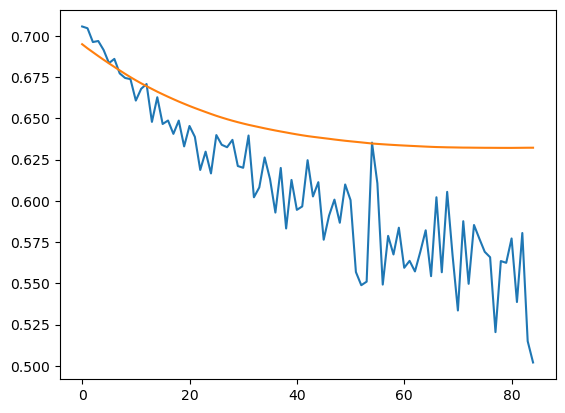

In [43]:
plt.plot(train_losses1)
plt.plot(val_losses1)

In [44]:
train_losses2, val_losses2 = train_baseline_model(model = nn_baseline2, num_epochs = 100, lr=1e-5)

Epoch 0: Training loss: 0.7183449268341064 |  Validation loss: 0.7076511383056641
Epoch 1: Training loss: 0.7111625075340271 |  Validation loss: 0.7070204615592957
Epoch 2: Training loss: 0.7009090185165405 |  Validation loss: 0.7064008116722107
Epoch 3: Training loss: 0.703715980052948 |  Validation loss: 0.7057963013648987
Epoch 4: Training loss: 0.7152898907661438 |  Validation loss: 0.7051937580108643
Epoch 5: Training loss: 0.7167094945907593 |  Validation loss: 0.7045917510986328
Epoch 6: Training loss: 0.7088561058044434 |  Validation loss: 0.703997015953064
Epoch 7: Training loss: 0.7083537578582764 |  Validation loss: 0.7034128308296204
Epoch 8: Training loss: 0.7156834602355957 |  Validation loss: 0.7028346657752991
Epoch 9: Training loss: 0.708924412727356 |  Validation loss: 0.7022620439529419
Epoch 10: Training loss: 0.7154191732406616 |  Validation loss: 0.7016949653625488
Epoch 11: Training loss: 0.7118022441864014 |  Validation loss: 0.7011260390281677
Epoch 12: Trainin

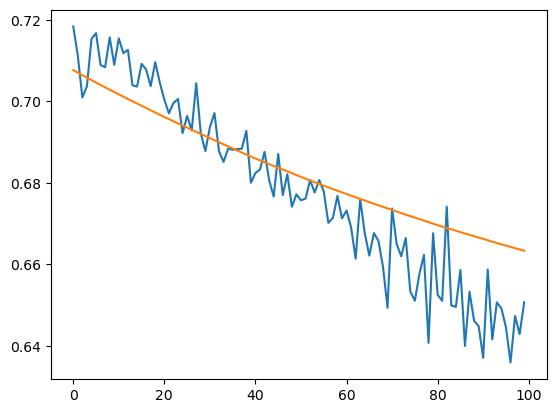

In [45]:
plt.plot(train_losses2)
plt.plot(val_losses2)

In [46]:
train_losses3, val_losses3 = train_baseline_model(model = nn_baseline3, num_epochs = 100, lr=1e-5)

Epoch 0: Training loss: 0.7155816555023193 |  Validation loss: 0.7054726481437683
Epoch 1: Training loss: 0.7050926685333252 |  Validation loss: 0.7046151161193848
Epoch 2: Training loss: 0.7068383693695068 |  Validation loss: 0.7037860751152039
Epoch 3: Training loss: 0.7060808539390564 |  Validation loss: 0.7029792666435242
Epoch 4: Training loss: 0.7033019065856934 |  Validation loss: 0.7021815180778503
Epoch 5: Training loss: 0.708252489566803 |  Validation loss: 0.7013818621635437
Epoch 6: Training loss: 0.7034416794776917 |  Validation loss: 0.7005912661552429
Epoch 7: Training loss: 0.692639172077179 |  Validation loss: 0.6998019814491272
Epoch 8: Training loss: 0.700727105140686 |  Validation loss: 0.6990378499031067
Epoch 9: Training loss: 0.7009348273277283 |  Validation loss: 0.6982824206352234
Epoch 10: Training loss: 0.6918163895606995 |  Validation loss: 0.6975263357162476
Epoch 11: Training loss: 0.6993655562400818 |  Validation loss: 0.696804940700531
Epoch 12: Training

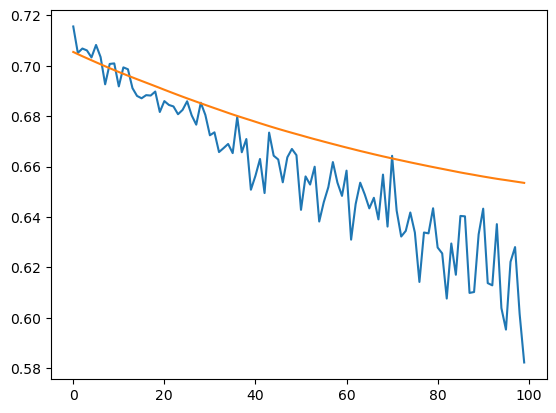

In [47]:
plt.plot(train_losses3)
plt.plot(val_losses3)

Running inference with each model

In [48]:
def inference_baseline_model(model):
    model.eval()
    y_test_pred = []
    test_y = []
    for idx, batch in enumerate(test_dataloader):
        y_test_pred.append(nn.Sigmoid()(model(batch[0].to(dtype=torch.float32))).detach())
        test_y.append(batch[1].detach())
    y_test_pred = torch.cat(y_test_pred)
    test_y = torch.cat(test_y)
    predictions = y_test_pred.detach().numpy().reshape(-1)
    auroc = roc_auc_score(test_y, predictions)
    auprc = average_precision_score(test_y, predictions)
    print(f"AUROC: {auroc}, AUPRC: {auprc}")

    # per drug inference
    res_df = pd.DataFrame(predictions, columns=["y_pred"])
    res_df["y_true"] = test_y
    res_df["drug"] = test_tcga_with_response.drug
    for d in res_df.drug.unique():
        try:
            subset_df = res_df[res_df.drug == d]
            auroc = roc_auc_score(subset_df["y_true"], subset_df["y_pred"])
            auprc = average_precision_score(subset_df["y_true"], subset_df["y_pred"])
            print(f"Drug {d} | AUROC = {auroc}, AUPRC = {auprc}")
            print(subset_df.shape)
            print(subset_df.y_true.value_counts())
        except:
            continue

In [49]:
inference_baseline_model(nn_baseline1)

AUROC: 0.42665964172813486, AUPRC: 0.5978472483260555
Drug DOXORUBICIN | AUROC = 0.5, AUPRC = 0.8121804121804124
(13, 3)
y_true
1    9
0    4
Name: count, dtype: int64
Drug VINBLASTINE | AUROC = 0.6666666666666667, AUPRC = 0.5
(4, 3)
y_true
0    3
1    1
Name: count, dtype: int64
Drug CISPLATIN | AUROC = 0.3434343434343434, AUPRC = 0.7098666837643517
(47, 3)
y_true
1    36
0    11
Name: count, dtype: int64
Drug GEMCITABINE | AUROC = 0.3142857142857143, AUPRC = 0.5011419054801407
(17, 3)
y_true
1    10
0     7
Name: count, dtype: int64
Drug DOCETAXEL | AUROC = 0.48571428571428577, AUPRC = 0.45979797979797976
(12, 3)
y_true
0    7
1    5
Name: count, dtype: int64
Drug PACLITAXEL | AUROC = 0.24836601307189543, AUPRC = 0.597116488483904
(26, 3)
y_true
1    17
0     9
Name: count, dtype: int64
Drug 5-FLUOROURACIL | AUROC = 0.476923076923077, AUPRC = 0.7857830203984049
(18, 3)
y_true
1    13
0     5
Name: count, dtype: int64
Drug CYCLOPHOSPHAMIDE | AUROC = 0.625, AUPRC = 0.9333765771265773
(

In [50]:
inference_baseline_model(nn_baseline2)

AUROC: 0.4032665964172814, AUPRC: 0.567174233342087
Drug DOXORUBICIN | AUROC = 0.4444444444444445, AUPRC = 0.6840659340659342
(13, 3)
y_true
1    9
0    4
Name: count, dtype: int64
Drug VINBLASTINE | AUROC = 1.0, AUPRC = 1.0
(4, 3)
y_true
0    3
1    1
Name: count, dtype: int64
Drug CISPLATIN | AUROC = 0.4065656565656566, AUPRC = 0.7217561504082608
(47, 3)
y_true
1    36
0    11
Name: count, dtype: int64
Drug GEMCITABINE | AUROC = 0.2571428571428572, AUPRC = 0.47544746103569635
(17, 3)
y_true
1    10
0     7
Name: count, dtype: int64
Drug DOCETAXEL | AUROC = 0.31428571428571433, AUPRC = 0.36757575757575756
(12, 3)
y_true
0    7
1    5
Name: count, dtype: int64
Drug PACLITAXEL | AUROC = 0.23529411764705882, AUPRC = 0.5492085141053413
(26, 3)
y_true
1    17
0     9
Name: count, dtype: int64
Drug 5-FLUOROURACIL | AUROC = 0.5846153846153845, AUPRC = 0.7662325921941306
(18, 3)
y_true
1    13
0     5
Name: count, dtype: int64
Drug CYCLOPHOSPHAMIDE | AUROC = 0.6666666666666667, AUPRC = 0.9396

In [51]:
inference_baseline_model(nn_baseline3)

AUROC: 0.4110642781875659, AUPRC: 0.5796305869710816
Drug DOXORUBICIN | AUROC = 0.4722222222222222, AUPRC = 0.7544363044363045
(13, 3)
y_true
1    9
0    4
Name: count, dtype: int64
Drug VINBLASTINE | AUROC = 0.6666666666666667, AUPRC = 0.5
(4, 3)
y_true
0    3
1    1
Name: count, dtype: int64
Drug CISPLATIN | AUROC = 0.4191919191919192, AUPRC = 0.727638634930883
(47, 3)
y_true
1    36
0    11
Name: count, dtype: int64
Drug GEMCITABINE | AUROC = 0.3571428571428572, AUPRC = 0.5352670858553211
(17, 3)
y_true
1    10
0     7
Name: count, dtype: int64
Drug DOCETAXEL | AUROC = 0.34285714285714286, AUPRC = 0.3705555555555555
(12, 3)
y_true
0    7
1    5
Name: count, dtype: int64
Drug PACLITAXEL | AUROC = 0.3006535947712418, AUPRC = 0.5749945168377109
(26, 3)
y_true
1    17
0     9
Name: count, dtype: int64
Drug 5-FLUOROURACIL | AUROC = 0.5384615384615384, AUPRC = 0.7989450217957004
(18, 3)
y_true
1    13
0     5
Name: count, dtype: int64
Drug CYCLOPHOSPHAMIDE | AUROC = 0.5416666666666667, AU

#### Model with all cell lines + pseudo labels and train patient data -- FOCUS

In [52]:
cl_aug_train_dataset = CustomCellLineDataSet(sample_df=cl_responses_df)

In [53]:
len(cl_aug_train_dataset)

226796

In [54]:
cl_aug_train_dataloader = DataLoader(cl_aug_train_dataset, batch_size=128, shuffle=False)

In [55]:
def assign_pseudo_label(model):
    model.eval()
    cl_aug_train_y_pseudo = []
    for idx, batch in enumerate(cl_aug_train_dataloader):
        cl_aug_train_y_pseudo.append(nn.Sigmoid()(model(batch[0].to(dtype=torch.float32))).detach().cpu())
    cl_aug_train_y_pseudo = torch.cat(cl_aug_train_y_pseudo).numpy()
    return cl_aug_train_y_pseudo

In [56]:
baseline1_pseudolabels = assign_pseudo_label(nn_baseline1)

In [57]:
baseline1_pseudolabels.shape

(226796, 1)

In [58]:
baseline2_pseudolabels = assign_pseudo_label(nn_baseline2)
baseline2_pseudolabels.shape

(226796, 1)

In [59]:
baseline3_pseudolabels = assign_pseudo_label(nn_baseline3)
baseline3_pseudolabels.shape

(226796, 1)

In [60]:
pseudolabels_df = pd.concat([pd.Series(baseline1_pseudolabels.reshape(-1)), pd.Series(baseline2_pseudolabels.reshape(-1)), pd.Series(baseline3_pseudolabels.reshape(-1))], axis=1)
pseudolabels_df.columns = ["baseline1_preds", "baseline2_preds", "baseline3_preds"]
pseudolabels_df.describe()

,baseline1_preds,baseline2_preds,baseline3_preds
count,226796.000000,226796.000000,226796.000000
mean,0.588173,0.514895,0.531516
std,0.046477,0.026124,0.030713
min,0.405241,0.420804,0.424679
25%,0.558169,0.497252,0.511038
50%,0.585764,0.513536,0.528858
75%,0.615500,0.530775,0.548627
max,0.854678,0.661160,0.733934


In [61]:
baseline1_preds_25th = pseudolabels_df.describe()["baseline1_preds"]["25%"]
baseline1_preds_75th = pseudolabels_df.describe()["baseline1_preds"]["75%"]

baseline2_preds_25th = pseudolabels_df.describe()["baseline2_preds"]["25%"]
baseline2_preds_75th = pseudolabels_df.describe()["baseline2_preds"]["75%"]

baseline3_preds_25th = pseudolabels_df.describe()["baseline3_preds"]["25%"]
baseline3_preds_75th = pseudolabels_df.describe()["baseline3_preds"]["75%"]

In [62]:
def convert_binary(prediction, lower_threshold, upper_threshold):
    if prediction >= upper_threshold:
        return 1
    elif prediction < lower_threshold:
        return 0
    else:
        return -1

In [63]:
# convert to binary based on 25th and 75th percentile for each set of pseudo labels
pseudolabels_df["baseline1_preds_binary"] = pseudolabels_df["baseline1_preds"].apply(lambda x: convert_binary(x, 0.3, 0.7))
pseudolabels_df["baseline2_preds_binary"] = pseudolabels_df["baseline2_preds"].apply(lambda x: convert_binary(x, 0.4, 0.6))
pseudolabels_df["baseline3_preds_binary"] = pseudolabels_df["baseline3_preds"].apply(lambda x: convert_binary(x, 0.4, 0.6))

In [64]:
pseudolabels_df["baseline1_preds_binary"].value_counts()

baseline1_preds_binary
-1    222712
 1      4084
Name: count, dtype: int64

In [65]:
pseudolabels_df["baseline2_preds_binary"].value_counts()

baseline2_preds_binary
-1    225229
 1      1567
Name: count, dtype: int64

In [66]:
pseudolabels_df["baseline3_preds_binary"].value_counts()

baseline3_preds_binary
-1    221179
 1      5617
Name: count, dtype: int64

In [67]:
def majority_vote(row):
    l1 = row["baseline1_preds_binary"]
    l2 = row["baseline2_preds_binary"]
    l3 = row["baseline3_preds_binary"]
    mod = mode([l1, l2, l3]).mode
    return mod
    
    

In [68]:
pseudolabels_df["majority_vote_pseudolabels"] = pseudolabels_df[["baseline1_preds_binary", "baseline2_preds_binary", "baseline3_preds_binary"]].apply(lambda x: majority_vote(x), axis =1)

In [69]:
pseudolabels_df[pseudolabels_df.majority_vote_pseudolabels != -1]

,baseline1_preds,baseline2_preds,baseline3_preds,baseline1_preds_binary,baseline2_preds_binary,baseline3_preds_binary,majority_vote_pseudolabels
293,0.707706,0.563935,0.600273,1,-1,1,1
2352,0.722865,0.568284,0.616424,1,-1,1,1
3107,0.713236,0.602535,0.572495,1,1,-1,1
5870,0.707757,0.562346,0.609957,1,-1,1,1
5950,0.723777,0.577792,0.608338,1,-1,1,1
...,...,...,...,...,...,...,...
225442,0.709981,0.586954,0.602728,1,-1,1,1
225861,0.714620,0.544260,0.610346,1,-1,1,1
225936,0.700873,0.559776,0.600537,1,-1,1,1
226009,0.716134,0.568006,0.605095,1,-1,1,1


In [70]:
confident_cl_responses_df = cl_responses_df[cl_responses_df.index.isin(pseudolabels_df[pseudolabels_df.majority_vote_pseudolabels != -1].index)].copy()
confident_cl_responses_df

,depmap_id,drug_name,auc
293,ACH-000538,JW-7-24-1,0.683189
2352,ACH-000538,NAVITOCLAX,0.731424
3107,ACH-000002,ERK5-IN-1,0.278288
5870,ACH-000681,ZM-447439,0.968264
5950,ACH-000848,ZM-447439,0.978364
...,...,...,...
225442,ACH-000848,NUTLIN-3A,0.937823
225861,ACH-000538,SGC0946,0.967654
225936,ACH-000681,SGC0946,0.985084
226009,ACH-000848,SGC0946,0.973766


In [71]:
confident_cl_responses_df["auc"] = pseudolabels_df[pseudolabels_df.majority_vote_pseudolabels!= -1]["majority_vote_pseudolabels"]
confident_cl_responses_df

,depmap_id,drug_name,auc
293,ACH-000538,JW-7-24-1,1
2352,ACH-000538,NAVITOCLAX,1
3107,ACH-000002,ERK5-IN-1,1
5870,ACH-000681,ZM-447439,1
5950,ACH-000848,ZM-447439,1
...,...,...,...
225442,ACH-000848,NUTLIN-3A,1
225861,ACH-000538,SGC0946,1
225936,ACH-000681,SGC0946,1
226009,ACH-000848,SGC0946,1


In [72]:
confident_cl_responses_df.auc.value_counts()

auc
1    3494
Name: count, dtype: int64

In [73]:
train_tcga_with_response

,patient.arr,drug.name,response,response_cat,drug
0,TCGA-G2-A2EC,Methotrexate,Partial Response,1,METHOTREXATE
1,TCGA-G2-A2EC,Doxorubicin,Partial Response,1,DOXORUBICIN
2,TCGA-G2-A2EC,Vinblastine,Partial Response,1,VINBLASTINE
3,TCGA-G2-A2EC,Cisplatin,Partial Response,1,CISPLATIN
4,TCGA-G2-A2EJ,Paclitaxel,Stable Disease,0,PACLITAXEL
...,...,...,...,...,...
754,TCGA-QF-A5YS,Paclitaxel,Complete Response,1,PACLITAXEL
755,TCGA-E6-A8L9,Paclitaxel,Complete Response,1,PACLITAXEL
756,TCGA-QS-A8F1,Paclitaxel,Clinical Progressive Disease,0,PACLITAXEL
757,TCGA-2E-A9G8,Paclitaxel,Complete Response,1,PACLITAXEL


In [74]:
# using data loaders to prevent execessive memory usage
class CustomCombinedDataSet(TensorDataset):
    def __init__(self, combined_sample_df): # sample_df must only consist of samples with drug name with a fingerprint
        self.sample_df = combined_sample_df.reset_index(drop=True) # ensure idx refers to a continuous set of values

    def __getitem__(self, idx):
        row = self.sample_df.iloc[idx]
        sample_name = row["patient.arr"]
        drug_name = row["drug"]
        if sample_name in tcga_train_df_vae.index: # using VAE version instead of mutation profiles
            mut_profile = tcga_train_df_vae.loc[sample_name].values
        if sample_name in tcga_test_df_vae.index:
            mut_profile = tcga_test_df_vae.loc[sample_name].values
        if sample_name in augmented_cl_df.index:
            mut_profile = augmented_cl_df.loc[sample_name].values
        drug_inp = drug_fp.loc[drug_name].values
        inp = []
        inp.extend(mut_profile)
        inp.extend(drug_inp)
        response = row["response_cat"]
        return torch.tensor(inp), response

    def __len__(self):
        return len(self.sample_df)
        

In [75]:
combined_dataset_df = pd.concat([confident_cl_responses_df.rename(columns={"depmap_id": "patient.arr", "drug_name": "drug", "auc": "response_cat"}), train_tcga_with_response])
combined_dataset_df.shape

(4253, 5)

In [76]:
combined_dataset_df.response_cat.value_counts()/combined_dataset_df.shape[0]

response_cat
1    0.948977
0    0.051023
Name: count, dtype: float64

In [77]:
combined_dataset = CustomCombinedDataSet(combined_dataset_df)

In [78]:
combined_dataloader = DataLoader(combined_dataset, batch_size=512, shuffle=True)

In [80]:
# del nn_augmented_full
# nn_augmented_full = BaseLineNN(2048 + 64, 256).to(device) # for sample 2
nn_augmented_full = BaseLineNN(2048 + 64, 128).to(device) # for sample 1

In [81]:
lr = 1e-6
optim_aug = torch.optim.Adam(nn_augmented_full.parameters(), lr = lr)

In [82]:
# training 
train_losses = []
val_losses = []
count = 0
for i in range(300):
    if (i+1) % 50 == 0: # scheduling
        lr /= 10
        optim_aug = torch.optim.Adam(nn_augmented_full.parameters(), lr = lr)
    for idx, batch in enumerate(combined_dataloader):
        optim_aug.zero_grad()
        criterion_aug = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([[0.6]]*len(batch[0])).to(device))
        y_pred_aug = nn_augmented_full(batch[0].to(device, dtype=torch.float32))
        loss_aug = criterion_aug(y_pred_aug, batch[1].view(-1, 1).to(device, dtype=torch.float32))
        loss_aug.backward()
        optim_aug.step()

    with torch.no_grad():
        val_loss = 0.0
        for idx, batch in enumerate(val_dataloader):
            criterion_aug = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([[0.6]]*len(batch[0])).to(device))
            val_loss += criterion_aug(nn_augmented_full(batch[0].to(device, dtype=torch.float32)), batch[1].view(-1, 1).to(device, dtype=torch.float32))
        val_loss /= (idx+1)

    print(f"Epoch {i}: Training loss: {loss_aug.detach().cpu().item()} |  Validation loss: {val_loss.detach().cpu().item()}")
    train_losses.append(loss_aug.detach().cpu().item())
    val_losses.append(val_loss.detach().cpu().item())

    if len(val_losses) > 2:
        if val_losses[-1]> val_losses[-2]:
            count +=1
    if count > 3:
        print("Converged")
        break

Epoch 0: Training loss: 0.4479164481163025 |  Validation loss: 0.5133196711540222
Epoch 1: Training loss: 0.45824748277664185 |  Validation loss: 0.5131986141204834
Epoch 2: Training loss: 0.45075902342796326 |  Validation loss: 0.5130795836448669
Epoch 3: Training loss: 0.44652923941612244 |  Validation loss: 0.5129602551460266
Epoch 4: Training loss: 0.4514090120792389 |  Validation loss: 0.5128411054611206
Epoch 5: Training loss: 0.45415163040161133 |  Validation loss: 0.5127232670783997
Epoch 6: Training loss: 0.4390246272087097 |  Validation loss: 0.5126054286956787
Epoch 7: Training loss: 0.44052475690841675 |  Validation loss: 0.5124885439872742
Epoch 8: Training loss: 0.44747671484947205 |  Validation loss: 0.5123721957206726
Epoch 9: Training loss: 0.44709253311157227 |  Validation loss: 0.5122564435005188
Epoch 10: Training loss: 0.44461512565612793 |  Validation loss: 0.512140154838562
Epoch 11: Training loss: 0.4477699398994446 |  Validation loss: 0.5120267868041992
Epoch 1

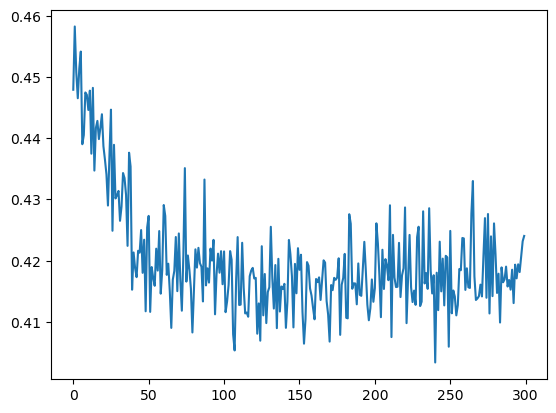

In [83]:
plt.plot(train_losses)

In [84]:
# inference
nn_augmented_full.eval()
y_test_pred = []
test_y = []
for idx, batch in enumerate(test_dataloader):
    y_test_pred.append(nn.Sigmoid()(nn_augmented_full(batch[0].to(device, dtype=torch.float32))).detach().cpu())
    test_y.append(batch[1].cpu())
y_test_pred = torch.cat(y_test_pred)
test_y = torch.cat(test_y)
y_test_pred.shape

torch.Size([203, 1])

In [85]:
predictions = y_test_pred.detach().cpu().numpy().reshape(-1)
predictions.shape

(203,)

In [86]:
auroc = roc_auc_score(test_y.numpy().reshape(-1), predictions)
auprc = average_precision_score(test_y, predictions)
print(f"AUROC: {auroc}, AUPRC: {auprc}")

AUROC: 0.5460484720758693, AUPRC: 0.6431684860271489


In [87]:
# per drug
res_df = pd.DataFrame(predictions, columns=["y_pred"])
res_df["y_true"] = test_y
res_df["drug"] = list(test_tcga_with_response["drug"])

In [88]:
res_df

,y_pred,y_true,drug
0,0.490423,0,METHOTREXATE
1,0.501151,0,DOXORUBICIN
2,0.506659,0,VINBLASTINE
3,0.480972,0,CISPLATIN
4,0.492467,0,GEMCITABINE
...,...,...,...
198,0.474518,1,CISPLATIN
199,0.485009,1,PACLITAXEL
200,0.483183,1,CISPLATIN
201,0.502054,1,PACLITAXEL


In [89]:
for d in res_df.drug.unique():
    try:
        subset_df = res_df[res_df.drug == d]
        auroc = roc_auc_score(subset_df["y_true"], subset_df["y_pred"])
        auprc = average_precision_score(subset_df["y_true"], subset_df["y_pred"])
        print(f"Drug {d} | AUROC = {auroc}, AUPRC = {auprc}")
        print(subset_df.shape)
        print(subset_df.y_true.value_counts())
    except:
        continue

Drug DOXORUBICIN | AUROC = 0.8611111111111112, AUPRC = 0.9376903960237295
(13, 3)
y_true
1    9
0    4
Name: count, dtype: int64
Drug VINBLASTINE | AUROC = 0.6666666666666667, AUPRC = 0.5
(4, 3)
y_true
0    3
1    1
Name: count, dtype: int64
Drug CISPLATIN | AUROC = 0.5353535353535354, AUPRC = 0.7906758665483813
(47, 3)
y_true
1    36
0    11
Name: count, dtype: int64
Drug GEMCITABINE | AUROC = 0.8428571428571429, AUPRC = 0.8618650793650794
(17, 3)
y_true
1    10
0     7
Name: count, dtype: int64
Drug DOCETAXEL | AUROC = 0.5714285714285715, AUPRC = 0.5033333333333333
(12, 3)
y_true
0    7
1    5
Name: count, dtype: int64
Drug PACLITAXEL | AUROC = 0.4836601307189543, AUPRC = 0.6291559415368138
(26, 3)
y_true
1    17
0     9
Name: count, dtype: int64
Drug 5-FLUOROURACIL | AUROC = 0.4153846153846154, AUPRC = 0.6584629925127662
(18, 3)
y_true
1    13
0     5
Name: count, dtype: int64
Drug CYCLOPHOSPHAMIDE | AUROC = 0.9166666666666667, AUPRC = 0.9866452991452993
(14, 3)
y_true
1    12
0    

In [90]:
# for DRP comparison
drugs_drp = ["DOXORUBICIN", "CISPLATIN", "PACLITAXEL", "GEMCITABINE", "5-FLUOROURACIL", "DOCETAXEL", "CYCLOPHOSPHAMIDE"]
subset_df2 = res_df[res_df.drug.isin(drugs_drp)]
print(subset_df2.shape)
auroc = roc_auc_score(subset_df2["y_true"], subset_df2["y_pred"])
auprc = average_precision_score(subset_df2["y_true"], subset_df2["y_pred"])
print(f"AUROC = {auroc}, AUPRC = {auprc}")

(147, 3)
AUROC = 0.5660130718954249, AUPRC = 0.7135870037221701


In [91]:
subset_df2[subset_df2.drug == "CYCLOPHOSPHAMIDE"]["y_true"].value_counts()

y_true
1    12
0     2
Name: count, dtype: int64

### Experimental Phase
Trying weak supervision - combine outputs from multiple label function using MajorityVoting to assign labels.

In [ ]:
# # trying another 4 supervised classifiers trained on patient data and predicting on CL augmented
# from sklearn.ensemble import RandomForestClassifier
# rf1 = RandomForestClassifier(random_state=42, n_estimators=50)
# rf2 = RandomForestClassifier(random_state=1, max_depth=10)
# rf3 = RandomForestClassifier(random_state=0)
# # rf4 = RandomForestClassifier(random_state=3, n_estimators=10)

In [ ]:
# rf3.fit(train_features, train_y)

In [ ]:
# with open("/data/ajayago/druid/intermediate/cs6220/rf3_augmented_cl_v2_pseudolabels.csv", "a") as f:
#     for idx, row in cl_responses_df.iterrows():
#         if row["drug_name"] in drug_fp.index:
#             row_inp = []
#             row_inp.extend(augmented_cl_df.loc[row["depmap_id"]].values)
#             row_inp.extend(drug_fp.loc[row["drug_name"]].values)
#             pred = rf3.predict(np.array(row_inp).reshape(1, -1))[0]
#             f.write(f"{pred}\n")
        

##### Combine weak labels from RF1, RF2, RF3 - Majority Voting

In [ ]:
# rf1_pred = pd.read_csv("/data/ajayago/druid/intermediate/cs6220/rf1_augmented_cl_v2_pseudolabels.csv", header=None)
# rf2_pred = pd.read_csv("/data/ajayago/druid/intermediate/cs6220/rf2_augmented_cl_v2_pseudolabels.csv", header=None)
# rf3_pred = pd.read_csv("/data/ajayago/druid/intermediate/cs6220/rf3_augmented_cl_v2_pseudolabels.csv", header=None)

In [ ]:
# import scipy.stats as st
# maj_labels = st.mode(np.concatenate((rf1_pred.values, rf2_pred.values, rf3_pred.values), axis = 1), axis = 1).mode

Train with these labels now

In [ ]:
# cl_aug_train_features = []
# cl_aug_train_y = []
# for idx, row in cl_responses_df.iterrows():
#     if row["drug_name"] in drug_fp.index:
#         row_inp = []
#         row_inp.extend(augmented_cl_df.loc[row["depmap_id"]].values)
#         row_inp.extend(drug_fp.loc[row["drug_name"]].values)
#         cl_aug_train_y.append(maj_labels[idx])
#         cl_aug_train_features.append(row_inp)

In [ ]:
# # Use pseudo labeled cell lines and patient train data to train
# cl_aug_features_tensor = torch.Tensor(cl_aug_train_features)

In [ ]:
# X_train = torch.cat((train_features_tensor, cl_aug_features_tensor), dim=0)
# X_train

In [ ]:
# y_train = torch.cat((train_y_tensor.view(-1, 1), torch.tensor(cl_aug_train_y).view(-1, 1)), dim = 0)

In [ ]:
# del nn_augmented_full

In [ ]:
# nn_augmented_full = BaseLineNN()

In [ ]:
# criterion_aug = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3/4]*X_train.shape[0]))
# optim_aug = torch.optim.Adam(nn_augmented_full.parameters(), lr = 1e-4)

In [ ]:
# # training 
# train_losses = []
# val_losses = []
# count = 0
# for i in range(500):
#     optim_aug.zero_grad()
#     y_pred_aug = nn_augmented_full(X_train.to(dtype=torch.float32))
#     loss_aug = criterion_aug(y_pred_aug, y_train.view(-1, 1).to(dtype=torch.float32))
#     loss_aug.backward()
#     optim_aug.step()

#     with torch.no_grad():
#         val_loss_aug = criterion_aug(nn_augmented_full(val_features_tensor.to(dtype=torch.float32)), val_y_tensor.view(-1, 1).to(dtype=torch.float32))

#     val_losses.append(val_loss_aug.detach().item())
#     print(f"Epoch {i}: Training loss: {loss_aug.detach().item()} |  Validation loss: {val_loss_aug.detach().item()}")
#     train_losses.append(loss_aug.detach().item())
#     if len(val_losses) > 2:
#         if val_losses[-1] > val_losses[-2]:
#             count += 1
#     if count > 3:
#         print("Converged")
#         break

In [ ]:
# plt.plot(train_losses)

In [ ]:
# # inference
# nn_augmented_full.eval()
# y_test_pred = nn.Sigmoid()(nn_augmented_full(test_features_tensor.to(dtype=torch.float32)))
# y_test_pred.shape

In [ ]:
# predictions = y_test_pred.detach().numpy().reshape(-1)
# print(predictions.shape)
# auroc = roc_auc_score(test_y, predictions)
# auprc = average_precision_score(test_y, predictions)
# print(f"AUROC: {auroc}, AUPRC: {auprc}")

In [ ]:
# # per drug
# res_df = pd.DataFrame(predictions, columns=["y_pred"])
# res_df["y_true"] = test_y
# res_df["drug"] = drugs

In [ ]:
# for d in res_df.drug.unique():
#     try:
#         subset_df = res_df[res_df.drug == d]
#         auroc = roc_auc_score(subset_df["y_true"], subset_df["y_pred"])
#         auprc = average_precision_score(subset_df["y_true"], subset_df["y_pred"])
#         print(f"Drug {d} | AUROC = {auroc}, AUPRC = {auprc}")
#         print(subset_df.shape)
#         print(subset_df.y_true.value_counts())
#     except:
#         continue